In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

In [3]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib as mpl

#Standard imports

In [4]:
!pip install pytorch_lightning
import torch
import numpy as np
import torch.nn as nn
import dynamic_selection as ds
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Subset, TensorDataset
from torchmetrics import Accuracy, AUROC
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection,BaseModel
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 60.8 MB/s eta 0:00:00


#Dataset

In [5]:
# Load dataset.
dataset = ds.data.load_spam()
d_in = dataset.input_size    # 57
d_out = dataset.output_size  # 2
# Normalize and split dataset.
mean = dataset.tensors[0].mean(dim=0)
dataset.tensors = (dataset.tensors[0] - mean, dataset.tensors[1])
train_dataset, val_dataset, test_dataset = ds.data.data_split(dataset)
dataset.features

array(['VelocityRef:1', '<xdot>', '<BattSoc>', '<BattPwr>',
       '<Cltch1State>', '<Cltch2State>', '<BattV>', '<TransGear>',
       '<EngSpd>', '<IntkVlvLift>', '<EngTrq>', '<ThrPosPct>',
       '<WgAreaPct>', '<EgrVlvAreaPct>', '<VarCompRatioPos>', '<Acc>',
       '<Dec>', '<IgSw>', '<Chrg>', 'TransGear', 'BrkCmd', 'Cltch1Cmd',
       '<MotTrq>', '<StartTrq>', 'StartCmd', 'MotTrqCmd', 'BattCrnt:1',
       'MotPwrElec:1', 'MotPwrMech:1', 'IntkVlvLiftCmd', 'FuelMainSoi',
       'FuelFlw'], dtype='<U17')

In [6]:
# Prepare dataloaders.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1024, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, pin_memory=True)

#Networks

In [7]:
# Set up networks
hidden = 128
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in))

In [8]:
# Pretrain predictor.
mask_layer = ds.utils.MaskLayer(append=True)
pretrain = MaskingPretrainer(predictor, mask_layer).cuda()
pretrain.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=15,#100
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 1.0601

--------Epoch 2--------
Val loss = 0.9985

--------Epoch 3--------
Val loss = 0.9954

--------Epoch 4--------
Val loss = 0.9903

--------Epoch 5--------
Val loss = 0.9852

--------Epoch 6--------
Val loss = 0.9837

--------Epoch 7--------
Val loss = 0.9777

--------Epoch 8--------
Val loss = 0.9858

--------Epoch 9--------
Val loss = 0.9783

--------Epoch 10--------
Val loss = 0.9836

Epoch 00010: reducing learning rate of group 0 to 2.0000e-04.
--------Epoch 11--------
Val loss = 0.9615

--------Epoch 12--------
Val loss = 0.9588

--------Epoch 13--------
Val loss = 0.9565

--------Epoch 14--------
Val loss = 0.9557

--------Epoch 15--------
Val loss = 0.9564



In [9]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer).cuda()

In [10]:
gdfs.fit(
    train_loader,
    val_loader,
    dataset.features,
    lr=1e-3,
    nepochs=3,#250
    start_temp=0.3,
    temp_steps=1,
    max_features=35,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True
    )

Starting training with temp = 0.3000

epoch is 0

--------Epoch 1 (1 total)--------
Val loss = 0.6054, Zero-temp loss = 0.6047

epoch is 1

--------Epoch 2 (2 total)--------
Val loss = 0.6031, Zero-temp loss = 0.6031

epoch is 2

11500
['<ThrPosPct>', '<xdot>', '<BattSoc>', '<Cltch2State>', '<BattV>', 'Cltch1Cmd', 'TransGear', '<Chrg>', 'FuelMainSoi', 'IntkVlvLiftCmd']
11600
['<xdot>', '<ThrPosPct>', '<BattSoc>', '<Cltch2State>', '<BattV>', 'Cltch1Cmd', 'TransGear', '<Chrg>', 'FuelMainSoi', '<IntkVlvLift>']
11700
['<xdot>', '<BattSoc>', '<ThrPosPct>', '<Cltch2State>', 'Cltch1Cmd', '<BattV>', 'TransGear', '<Chrg>', 'FuelMainSoi', '<IntkVlvLift>']
11800
['<ThrPosPct>', '<xdot>', '<BattSoc>', '<Cltch2State>', '<BattV>', 'Cltch1Cmd', 'TransGear', '<Chrg>', '<IntkVlvLift>', 'FuelMainSoi']
11900
['<ThrPosPct>', '<BattSoc>', '<xdot>', '<Cltch2State>', 'Cltch1Cmd', '<BattV>', 'TransGear', '<Chrg>', '<IntkVlvLift>', 'FuelMainSoi']
12000
['<ThrPosPct>', '<xdot>', '<BattSoc>', '<Cltch2State>', '<

In [11]:
gdfs.selector.load_state_dict(torch.load('/content/drive/MyDrive/selPre/selector'))
gdfs.predictor.load_state_dict(torch.load('/content/drive/MyDrive/selPre/predictor'))

<All keys matched successfully>

# Evaluate performance

- AUROC and top-1 accuracy increase quickly with the number of selections
- Performance can often be improved by increasing the `patience` parameter, or increasing the number of temperature steps (`temp_steps`)

In [12]:
# For saving results.
num_features = list(range(1, 11)) + list(range(15, 30, 5))
auroc_list = []
acc_list = []

# Metrics (softmax is applied automatically in recent versions of torchmetrics).
auroc_metric = lambda pred, y: AUROC(task='multiclass', num_classes=d_out)(pred.softmax(dim=1), y)
acc_metric = Accuracy(task='multiclass', num_classes=d_out)

# Evaluate.
for num in num_features:
    auroc, acc = gdfs.evaluate(test_loader, num, (auroc_metric, acc_metric))
    auroc_list.append(auroc)
    acc_list.append(acc)
    print(f'Num = {num}, AUROC = {100*auroc:.2f}, Acc = {100*acc:.2f}')

Num = 1, AUROC = 82.07, Acc = 61.75
Num = 2, AUROC = 84.43, Acc = 67.34
Num = 3, AUROC = 84.50, Acc = 67.46
Num = 4, AUROC = 85.97, Acc = 67.77
Num = 5, AUROC = 85.53, Acc = 68.33
Num = 6, AUROC = 85.27, Acc = 68.12
Num = 7, AUROC = 85.88, Acc = 70.36
Num = 8, AUROC = 85.88, Acc = 70.13
Num = 9, AUROC = 85.88, Acc = 70.37
Num = 10, AUROC = 85.94, Acc = 69.94
Num = 15, AUROC = 86.48, Acc = 69.11
Num = 20, AUROC = 89.95, Acc = 74.34
Num = 25, AUROC = 90.00, Acc = 74.95


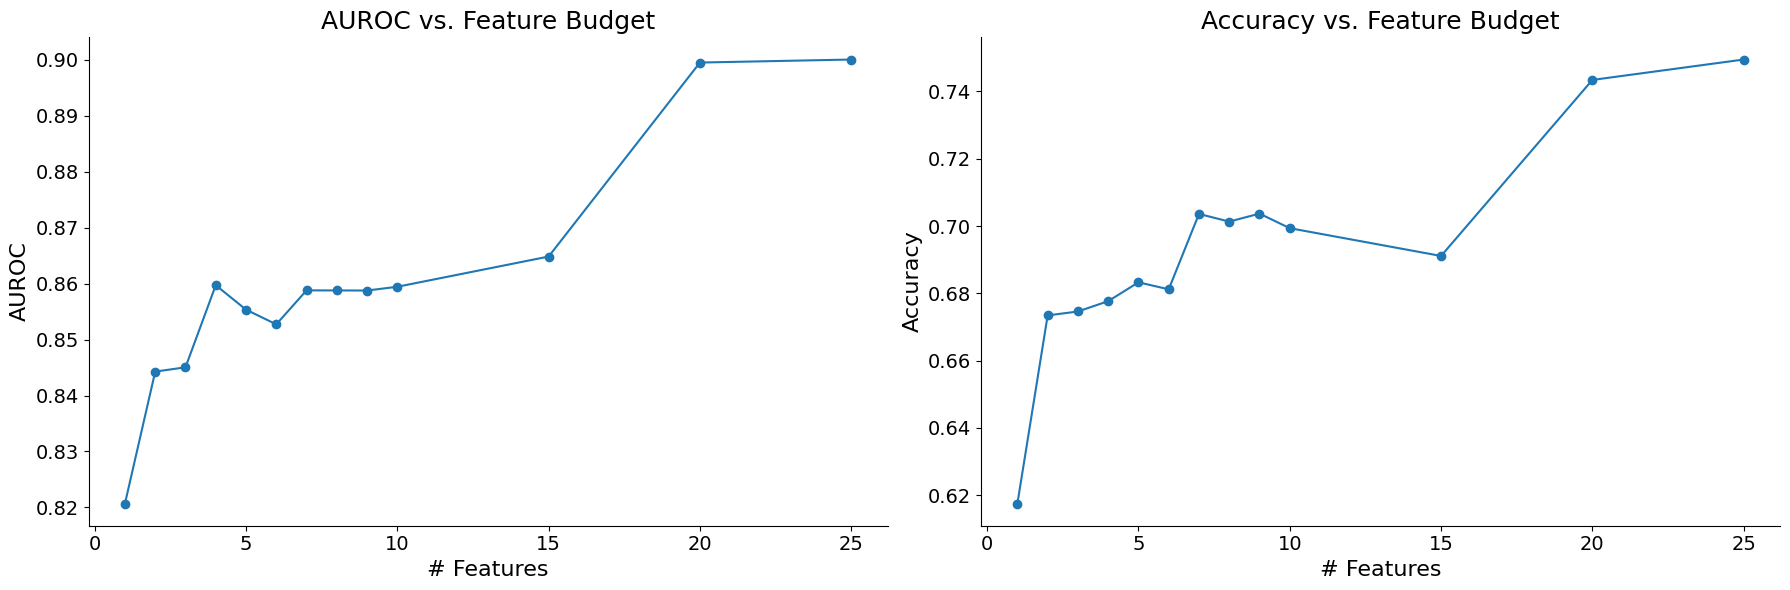

In [13]:
# Plot results
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))

# AUROC
plt.sca(axarr[0])
plt.plot(num_features, auroc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('AUROC', fontsize=16)
plt.title('AUROC vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Accuracy
plt.sca(axarr[1])
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

In [14]:
cost_false_positive = 2
cost_false_negative = 4

x , y_train_tensor = ds.data.get_xy(train_dataset)
x_np=x.numpy()
x_train_df=pd.DataFrame.from_records(x_np)
unique_elements, counts = torch.unique(y_train_tensor, return_counts=True)
for i in range(unique_elements.size(0)):
  if unique_elements[i]==0:
    non_fault = counts[i]
    break
total = torch.sum(counts)

x , y_val_tensor = ds.data.get_xy(val_dataset)
x_np=x.numpy()
x_cv_df=pd.DataFrame.from_records(x_np)
unique_elements, counts = torch.unique(y_val_tensor, return_counts=True)
for i in range(unique_elements.size(0)):
  if unique_elements[i]==0:
    non_fault += counts[i]
total += torch.sum(counts)

P_present = non_fault/total
P_absent = 1 - P_present

In [15]:
# helper function to calculate probability of correctly giving signal when present
def get_signal_present(prediction, ground_truth):
    present_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] == 0:
            present_index.append(i)

    counter = 0
    for index in present_index:
        if prediction[index] == 0:
            counter += 1

    return counter/len(present_index)

# helper function to calculate probability of correctly giving signal when present
# there should be a more generic way using operator module to merge this with the one above.
def get_no_signal_absent(prediction, ground_truth):
    absent_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] != 0:
            absent_index.append(i)

    counter = 0
    for index in absent_index:
        if prediction[index] != 0:
            counter += 1
    return counter/len(absent_index)

In [16]:
def get_expected_cost(prediction,GT_tensor):
  # get P(signal|present) and P(no signal|absent)
    ground_truth = GT_tensor.tolist()
    #prediction = prediction_t.tolist()
    P_signal_present = get_signal_present(prediction, ground_truth)
    P_no_signal_absent = get_no_signal_absent(prediction, ground_truth)
    P_signal_absent = 1 - P_no_signal_absent
    P_no_signal_present = 1 - P_signal_present

  # get P(signal)
    P_signal = P_present * P_signal_present + P_absent * P_signal_absent
    P_no_signal = 1 - P_signal

  # bayesian probability
    P_absent_signal = (P_signal_absent * P_absent) / P_signal
    P_present_signal = (P_signal_present * P_present) / P_signal
    P_absent_no_signal = (P_no_signal_absent * P_absent) / P_no_signal
    P_present_no_signal = (P_no_signal_present * P_present) / P_no_signal

  #calculate the evoi
    evoi = P_signal * min(cost_false_positive * P_absent_signal, cost_false_negative * P_present_signal) + P_no_signal * min(cost_false_positive * P_absent_no_signal, cost_false_negative * P_present_no_signal)

    return evoi

# Plot selections

In [17]:
# Generate selections for entire test set.
num_features = range(1, 25)
p_list = []

for num in num_features:
  print(str(num)+'\n')
  x, y = ds.data.get_xy(test_dataset)
  x_np=x.numpy()
  x_test_df=pd.DataFrame(x_np)
  pred1, x_masked, m = gdfs(x.cuda(), max_features=num)
  pred=(pred1.cpu()).detach().numpy()
  pred = np.argmax(pred, axis=-1)
  p = m.mean(dim=0)
  p_list.append(p.cpu().numpy())

  sensors_index=np.array(p_list)
  sorted_indices = np.flip(np.argsort(sensors_index))
  sensors=[]
  for i in range(0,num):
    sensors = np.append(sensors, dataset.features[sorted_indices[0][i]])
  sensors=sensors.tolist()
  print(sensors)
  base_indices=sorted_indices[0][num:].tolist()
  sorted_indices=sorted_indices[0][0:num].tolist()
  print(get_expected_cost(pred,y))


1

['<BattSoc>']
tensor(1.1884)
2

['<BattSoc>', '<ThrPosPct>']
tensor(0.9838)
3

['<BattSoc>', '<ThrPosPct>', '<BattV>']
tensor(0.9937)
4

['<BattSoc>', '<xdot>', '<BattV>', '<ThrPosPct>']
tensor(1.0292)
5

['<BattSoc>', '<BattV>', '<xdot>', '<Cltch2State>', '<ThrPosPct>']
tensor(1.0009)
6

['<BattV>', '<xdot>', '<BattSoc>', '<Cltch2State>', '<ThrPosPct>', 'Cltch1Cmd']
tensor(1.0003)
7

['<xdot>', '<BattSoc>', '<Cltch2State>', '<BattV>', '<ThrPosPct>', 'Cltch1Cmd', 'TransGear']
tensor(0.9176)
8

['<Cltch2State>', '<xdot>', '<BattSoc>', '<BattV>', '<ThrPosPct>', 'Cltch1Cmd', 'TransGear', 'IntkVlvLiftCmd']
tensor(0.9328)
9

['<BattV>', '<xdot>', '<BattSoc>', '<Cltch2State>', '<ThrPosPct>', 'TransGear', 'Cltch1Cmd', '<IntkVlvLift>', 'IntkVlvLiftCmd']
tensor(0.9266)
10

['<BattV>', '<xdot>', '<BattSoc>', '<Cltch2State>', '<ThrPosPct>', 'Cltch1Cmd', '<Chrg>', 'TransGear', '<IntkVlvLift>', 'IntkVlvLiftCmd']
tensor(0.9433)
11

['<BattV>', '<xdot>', '<BattSoc>', '<Cltch2State>', 'Cltch1Cmd', 